<a href="https://colab.research.google.com/github/Ajay-user/ML-DL-RL-repo/blob/master/Image%20Classification/Mnist_Model_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Import data

The MNIST dataset is very popular machine learning dataset, consisting of 70000 grayscale images of handwritten digits, of dimensions 28x28.



In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [6]:
print('training image set shape',x_train.shape)
print('training label set shape',y_train.shape)
print('testing image set shape',x_test.shape)
print('testing label set shape',y_test.shape)

training image set shape (60000, 28, 28)
training label set shape (60000,)
testing image set shape (10000, 28, 28)
testing label set shape (10000,)


In [7]:
# preprocessing

x_train_scaled, x_test_scaled = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train_scaled = x_train_scaled[..., tf.newaxis].astype("float32")
x_test_scaled = x_test_scaled[..., tf.newaxis].astype("float32")

In [8]:
# create training and testing datasets
# shuffling and batching
train_ds = tf.data.Dataset.from_tensor_slices((x_train_scaled,y_train)).shuffle(60000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test_scaled,y_test)).batch(32)

print('training dataset ',train_ds.element_spec)
print('testing dataset', test_ds.element_spec)

training dataset  (TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))
testing dataset (TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))


## Visualize the dataset

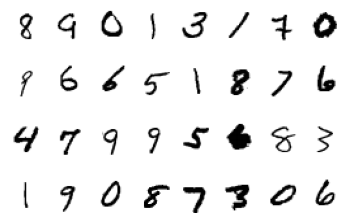

In [9]:
images , labels = next(iter(train_ds))
index = 0
for image in images:
  index +=1
  plt.subplot(4,8,index)
  plt.imshow(np.reshape(image.numpy(),(28,28)), cmap=plt.cm.binary)
  plt.axis('off')

## Building a simple model

### Loss function and Optimizer

In [10]:
# let's use sparse categorical cross entopy loss as the loss function and 
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Adam optimizer 
optimizer = tf.keras.optimizers.Adam()

### Simple model
Build the tf.keras model using the Keras model subclassing API:



In [11]:
class SimpleModel(tf.keras.Model):
  def __init__(self):
    super(SimpleModel, self).__init__()
    self.flatten = tf.keras.layers.Flatten()
    self.d1 = tf.keras.layers.Dense(32, activation='relu')
    self.output_layer = tf.keras.layers.Dense(10)

  def call(self, x):
    x = self.flatten(x)
    x = self.d1(x)
    x = self.output_layer(x)
    return x

In [12]:
# instantiate simple model instance
my_simple_model = SimpleModel()

# Define metrics to measure the loss and the accuracy of the model

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [13]:
# Use tf.GradientTape to train the model:

def model_training(images, labels):
  with tf.GradientTape() as tape:
    # make predictions using the model
    predictions = my_simple_model(images)
    # compute loss 
    loss = loss_object(labels, predictions)
  # backpropagate to compute the gradients
  gradients = tape.gradient(loss,my_simple_model.trainable_variables)
  # optimizer apply the gradients 
  optimizer.apply_gradients(zip(gradients, my_simple_model.trainable_variables))
  # metrics
  train_loss(loss)
  train_accuracy(labels, predictions)

def model_testing(images, labels):
  with tf.GradientTape() as tape:
    # make prediciton
    predictions = my_simple_model(images)
    # calcualte loss
    loss = loss_object(labels, predictions)
  # metrics
  test_loss(loss)
  test_accuracy(labels, predictions)    

### Training

In [14]:
# TRAIN THE MODEL 

NUM_EPOCHS = 5

for epoch in range(NUM_EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for image_batch, label_batch in train_ds:
    model_training(image_batch, label_batch)

  for image_batch, label_batch in test_ds:
    model_testing(image_batch, label_batch)

  print(
  f'Epoch {epoch + 1}, '
  f'Loss: {train_loss.result()}, '
  f'Accuracy: {train_accuracy.result() * 100}, '
  f'Test Loss: {test_loss.result()}, '
  f'Test Accuracy: {test_accuracy.result() * 100}')


Epoch 1, Loss: 0.3593817949295044, Accuracy: 90.08332824707031, Test Loss: 0.20582059025764465, Test Accuracy: 94.01000213623047
Epoch 2, Loss: 0.18898236751556396, Accuracy: 94.5433349609375, Test Loss: 0.16898347437381744, Test Accuracy: 94.80999755859375
Epoch 3, Loss: 0.15238144993782043, Accuracy: 95.55166625976562, Test Loss: 0.13899147510528564, Test Accuracy: 95.92000579833984
Epoch 4, Loss: 0.1298263520002365, Accuracy: 96.15332794189453, Test Loss: 0.12391229718923569, Test Accuracy: 96.1500015258789
Epoch 5, Loss: 0.1133614256978035, Accuracy: 96.62667083740234, Test Loss: 0.13105115294456482, Test Accuracy: 95.76000213623047


## Building Convolutional Neural Networks

### CNN model
Simple CNN model
> Model architecture 
* Covolution layer with 32 filters and kernel size 3*3
* Max pooling layer 
* Dense layer with 32 units
* output layer with 10 units

In [15]:
class CNNModel(tf.keras.Model):
  def __init__(self):
    super(CNNModel, self).__init__()

    self.cnn = tf.keras.layers.Conv2D(32,3, input_shape=(28,28,1))
    self.maxpool = tf.keras.layers.MaxPool2D()
    self.flatten = tf.keras.layers.Flatten()
    self.d1 = tf.keras.layers.Dense(32, activation='relu')
    self.output_layer = tf.keras.layers.Dense(10)

  def call(self, x):

    x = self.cnn(x)
    x = self.maxpool(x)
    x = self.flatten(x)
    x = self.d1(x)
    x = self.output_layer(x)
    return x

### Loss function and Optimizer

In [16]:
# LOSS FUCNTION AND OPTIMIZER
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

# Define metrics to measure the loss and the accuracy of the model

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Instantiate the cnn model
cnn = CNNModel()

In [17]:
# training util 

def train_cnn(images, labels):
  with tf.GradientTape() as tape:
    # make predicitons
    predictions = cnn(images)
    # compute loss
    loss = loss_object(labels, predictions)
  # backpropagation
  gradients = tape.gradient(loss, cnn.trainable_variables)
  # apply the gradients using the optimizer
  optimizer.apply_gradients(zip(gradients, cnn.trainable_variables))
  # metrics
  train_loss(loss)
  train_accuracy(labels, predictions)
  

def test_cnn(images, labels):
  with tf.GradientTape() as tape:
    # make predicitons
    predictions = cnn(images)
    # compute loss
    loss = loss_object(labels, predictions)
  # metrics
  test_loss(loss)
  test_accuracy(labels, predictions)


### Training

In [18]:
# TRAIN THE MODEL 

NUM_EPOCHS = 5

for epoch in range(NUM_EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for image_batch, label_batch in train_ds:
    train_cnn(image_batch, label_batch)

  for image_batch, label_batch in test_ds:
    test_cnn(image_batch, label_batch)

  print(
  f'Epoch {epoch + 1}, '
  f'Loss: {train_loss.result()}, '
  f'Accuracy: {train_accuracy.result() * 100}, '
  f'Test Loss: {test_loss.result()}, '
  f'Test Accuracy: {test_accuracy.result() * 100}')

Epoch 1, Loss: 0.24376164376735687, Accuracy: 92.89833068847656, Test Loss: 0.11082088202238083, Test Accuracy: 96.81999969482422
Epoch 2, Loss: 0.098697729408741, Accuracy: 97.08999633789062, Test Loss: 0.08762190490961075, Test Accuracy: 97.19999694824219
Epoch 3, Loss: 0.06808129698038101, Accuracy: 97.95667266845703, Test Loss: 0.0877525582909584, Test Accuracy: 97.33999633789062
Epoch 4, Loss: 0.0525793693959713, Accuracy: 98.33833312988281, Test Loss: 0.06433206051588058, Test Accuracy: 97.98999786376953
Epoch 5, Loss: 0.04107508808374405, Accuracy: 98.74166870117188, Test Loss: 0.06718200445175171, Test Accuracy: 98.0


## Building a model with Embedding layer

### Embedding model
Simple model with embedding layer
> Model architecture 
* Flatten layer 
* Embedding layer with input dimension 784 and output dimension 3
* Dense layer with 32 units
* Output layer with 10 units

In [46]:
class EmbeddingModel(tf.keras.Model):
  def __init__(self):
    super(EmbeddingModel, self).__init__()

    self.flatten = tf.keras.layers.Flatten()
    self.embedding = tf.keras.layers.Embedding(input_dim=784, output_dim=3)
    self.d1 = tf.keras.layers.Dense(32, activation='relu')
    self.output_layer = tf.keras.layers.Dense(10)

  def call(self, x):
    x = self.flatten(x)
    x = self.embedding(x)
    x = self.flatten(x)
    x = self.d1(x)
    x = self.output_layer(x)
    return x

### Loss function and Optimizer 

In [47]:
# LOSS FUCNTION AND OPTIMIZER
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

# Define metrics to measure the loss and the accuracy of the model

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Instantiate the cnn model
embed_model = EmbeddingModel()

In [48]:
# training util 

def train_embeddings(images, labels):
  with tf.GradientTape() as tape:
    # make predicitons
    predictions = embed_model(images)
    # compute loss
    loss = loss_object(labels, predictions)
  # backpropagation
  gradients = tape.gradient(loss, embed_model.trainable_variables)
  # apply the gradients using the optimizer
  optimizer.apply_gradients(zip(gradients, embed_model.trainable_variables))
  # metrics
  train_loss(loss)
  train_accuracy(labels, predictions)
  

def test_embeddings(images, labels):
  with tf.GradientTape() as tape:
    # make predicitons
    predictions = embed_model(images)
    # compute loss
    loss = loss_object(labels, predictions)
  # metrics
  test_loss(loss)
  test_accuracy(labels, predictions)


### Training 

In [49]:
# Dataset for training and testing
train_data = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(1000).batch(32)
test_data = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(32)

# TRAIN THE MODEL 

NUM_EPOCHS = 5

for epoch in range(NUM_EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for image_batch, label_batch in train_data:
    train_embeddings(image_batch, label_batch)

  for image_batch, label_batch in test_data:
    test_embeddings(image_batch, label_batch)

  print(
  f'Epoch {epoch + 1}, '
  f'Loss: {train_loss.result()}, '
  f'Accuracy: {train_accuracy.result() * 100}, '
  f'Test Loss: {test_loss.result()}, '
  f'Test Accuracy: {test_accuracy.result() * 100}')

Epoch 1, Loss: 0.41862934827804565, Accuracy: 87.7266616821289, Test Loss: 0.27844977378845215, Test Accuracy: 91.73999786376953
Epoch 2, Loss: 0.23808631300926208, Accuracy: 93.15499877929688, Test Loss: 0.20654818415641785, Test Accuracy: 94.06999969482422
Epoch 3, Loss: 0.18040068447589874, Accuracy: 94.74666595458984, Test Loss: 0.1782992035150528, Test Accuracy: 94.63999938964844
Epoch 4, Loss: 0.14412806928157806, Accuracy: 95.86499786376953, Test Loss: 0.1638914793729782, Test Accuracy: 95.18000030517578
Epoch 5, Loss: 0.1171087920665741, Accuracy: 96.58499908447266, Test Loss: 0.15164095163345337, Test Accuracy: 95.59000396728516


### Sequential model 
We can build models fast using the Sequential API. Sequential groups a linear stack of layers into a tf.keras.Model.

This is just to illustrate the power tensorflow bring to us 

In [29]:
model = tf.keras.Sequential([
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Embedding(input_dim=784, output_dim=3),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(32,'relu'),
                             tf.keras.layers.Dense(10)

])
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.fit(train_data , epochs=3)

Epoch 1/3
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4096 - accuracy: 0.8773
Epoch 2/3
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2173 - accuracy: 0.9363
Epoch 3/3
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1652 - accuracy: 0.9517
